# Networks: graphs and trees

I've put together a Jupyter notebook to help me sort out and understand various concepts concerning graphs and nd their implementation in Python. Sometime in the future I'll do the same for trees.

In [1]:
import pandas as pd
import networkx as nx
import json
import seaborn as sns

In [2]:
%pylab inline
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


# Graphs

To help make some of these ideas more concrete, I'm playing around with the character graph data from Les Misérables. This has been wonderfully visualized by Mike Bostock [using D3](https://bl.ocks.org/mbostock/4062045). That link also provides the data in JSON format. There is also a GML version available [here](https://networkdata.ics.uci.edu/data.php?id=109). Ideally I should just be able to load this into networkx, but having run into trouble with that I'm instead using this as an opportunity to gain some experience with the pandas merge function.

First, I open the JSON file and store the edge and node information in separate dataframes.

In [3]:
mis_file = open('assets/data/miserables.json')
les_mis_json = json.load(mis_file)
mis_links = pd.DataFrame(les_mis_json['links'])
mis_nodes = pd.DataFrame(les_mis_json['nodes'])

Using pandas.merge, associate the source and target nodes with the actual character names.

In [4]:
edge_list_df = pd.merge(mis_links,mis_nodes,left_on='source',right_index=True)
edge_list_df = pd.merge(edge_list_df,mis_nodes,left_on='target',right_index=True,suffixes=('_source','_target'))

Now I drop the information I don't want.

In [5]:
edge_list_df.drop(['group_source','group_target','source','target'],axis=1,inplace=True)

In [6]:
le_graph = nx.from_pandas_dataframe(edge_list_df,'name_source','name_target')

In [7]:
print "Number of nodes (characters) in this graph is", le_graph.order() # number of nodes
print "Number of edges in this graph is", len(le_graph.edges()) # number of edges
print "Graph diamer is", nx.diameter(le_graph) # maximum eccentricity

Number of nodes (characters) in this graph is 77
Number of edges in this graph is 254
Graph diamer is 5


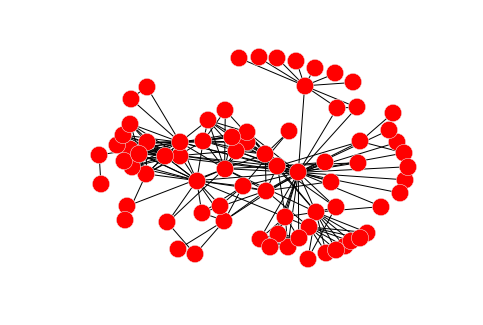

In [12]:
nx.draw(le_graph)

The default graph drawing in networkx is not bad (in this specific case), but it's not particularly helpful, especially without labels. Although these can be included, the result is even less illuminating.

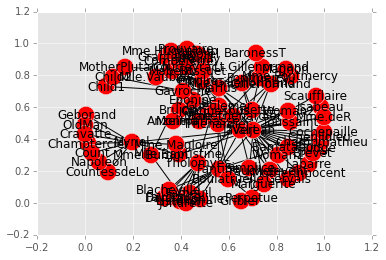

In [13]:
nx.draw_networkx(le_graph)

In [27]:
nx.write_graphml(le_graph,'miserables.graphml')



    graphml2gv miserables.graphml > miserables.gv
    dot -Tpng miserables.gv > mis_dot.png
    
Where `dot` is the graphviz command to produce a particular graph layout. Also available are `neato`, `fdp`, and a few others. It all depends on the characteristics of the graph and what looks the best.

After this processing, we can visualize the graph using GraphViz:

![mis_fdp](assets/img/posts/mis_fdp.png)

This is much clearer!

In [ ]:
nx.eigenvector_centrality

### Measurements of centrality

Centrality, as a general idea, is meant to quantify the importance of a vertex within a network. There are different ways that this can be done, and one's choice for a centrality metric often depends on what the graph is actually representing and the nature of the edge relationships.

That said, some common measurements of centrality are:
 - degree centrality
     > Degree is the most straightforward measure of importance. It is evaluated as the degree `d` of a node divided by the maximum possible number of connections (`n-1` in a graph with `n` nodes).
 - closeness centrality
     > Closeness probably best aligns with our intuitive idea of what it means to be central. It looks at the shortest paths from the node of interest to all other nodes, sums these paths, and then takes the reciprocal. This is evaluated as $C(v) = \frac{n - 1}{\sum d(v, u)}$, where $d(v,u)$ represents the shortest path between nodes $v$ and $u$.
 - betweenness centrality
     > Betweenness quantifies the importance of a node's role in linking together other vertices. This is especially important if edges represent the flow of something. It is evaluated as $C_B(v) =\sum \frac{\sigma(s, t|v)}{\sigma(s, t)}$, where $\sigma(s, t|v)$ is the number of shortest paths that pass through $v$ and $\sigma(s, t)$ is the total number of shortest paths.
 - eigenvector centrality
     > Computed using the adjacency matric, eigenvector centrality quantifies the idea that a node is important if it is linked to by other important nodes. It is a measure of influence, and Google's PageRank is apparently a variation of this method.

In [8]:
degrees = le_graph.degree()

bw_cen = nx.betweenness_centrality(le_graph) # check the documentation, what is this actually calc?

eig_cen = nx.centrality.eigenvector_centrality(le_graph)

cls_cen = nx.centrality.closeness_centrality(le_graph)

deg_cen = nx.centrality.degree_centrality(le_graph)

In [9]:
bw = pd.Series(bw_cen)
eig = pd.Series(eig_cen)
cls = pd.Series(cls_cen)
deg = pd.Series(deg_cen)

In [25]:
bw_df = pd.DataFrame(bw.sort_values(),columns=['Betweenness'])
cls_df = pd.DataFrame(cls.sort_values(),columns=['Closeness'])
deg_df = pd.DataFrame(deg.sort_values(),columns=['Degree'])
eig_df = pd.DataFrame(eig.sort_values(),columns=['Eigenvector'])

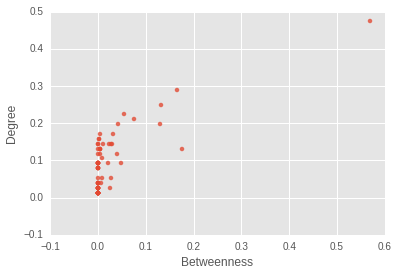

In [26]:
fig = figure()
sns.regplot(bw.sort_index(),deg.sort_index(),fit_reg=False,scatter=True)
ax = fig.axes
ax[0].set_xlabel('Betweenness')
ax[0].set_ylabel('Degree')

The outlier in the top right corner is Valjean, by far the most central character in the story. It's interesting to note, however, there are some measures of centrality that do not place Valjean at the top. Eigenvector centrality actually places him second to Gavroche, the intrepid little street urchin.

As a bit of an aside, networkx has built-in methods for generating trees from more general graphs using breadth-first search or depth-first search. We can see what these look like when using Valjean as the root node.

In [25]:
bfs = nx.breadth_first_search.bfs_tree(le_graph,'Valjean')
dfs = nx.depth_first_search.dfs_tree(le_graph,'Valjean')

In [28]:
nx.write_graphml(bfs,'mis_bfs.graphml')
nx.write_graphml(dfs,'mis_dfs.graphml')

The BFS tree is
![mis_bfs](assets/img/posts/mis_bfs_fdp.png)

The DFS tree is
![mis_bfs](assets/img/posts/mis_dfs_dot.png)

There is plenty more to discuss concerning graphs, such as path search algorithms like Dijkstra and Bellman-Ford, and plenty more besides to say about trees. I suppose that'll just have to wait.